# U-Net for Nuclei Segmentation (BBBC039)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thawn/ttt-workshop-cnn/blob/main/book/pair_programming/unet_bbbc039_pair_programming.ipynb)

Note: this notebook requires a GPU. Please switch to T4 GPU using the drop down menu in the top right of the colab interface:

![switch to GPU](assets/change_runtime.png)

## We train a small U-Net on the BBBC039 dataset

In [1]:
# Dependency management
import sys, subprocess
for p in ['torch', 'torchsummary', 'numpy', 'matplotlib', 'scikit-image', 'tqdm']:
    try:
        __import__(p)
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', p, '-q'])

In [2]:
from zipfile import ZipFile
from urllib.request import urlopen
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

# Random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device ## Mac OS metal
print(f"Using device: {device}")

Using device: mps


In [3]:
# Download the BBBC039 dataset
# https://data.broadinstitute.org/bbbc/BBBC039/

image_URL = "https://data.broadinstitute.org/bbbc/BBBC039/images.zip"
mask_URL = "https://data.broadinstitute.org/bbbc/BBBC039/masks.zip"
urls = [image_URL, mask_URL]
data_path = Path('data')
label_path = data_path / 'masks'
image_path = data_path / 'images'
data_path.mkdir(exist_ok=True)
zip_paths = [data_path / 'images.zip', data_path / 'masks.zip']


for zip_path, url in zip(zip_paths, urls):
    if not zip_path.exists():
        with urlopen(url) as r:
            open(zip_path, 'wb').write(r.read())
if not image_path.exists():
    with ZipFile(data_path / 'images.zip') as z: z.extractall(data_path)
if not label_path.exists():
    with ZipFile(data_path / 'masks.zip') as z: z.extractall(data_path)


In [4]:
# Dataset
class Nuclei(Dataset):
    def __init__(self, root=data_path, size=128):
        images = sorted((root/'images').glob('*.tif'))
        labels = sorted((root/'masks').glob('*.png'))
        self.pairs = list(zip(images, labels))
        self.size = size
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        x = imread(self.pairs[i][0], as_gray=True).astype(np.float32)
        y = imread(self.pairs[i][1])[:,:,0].astype(np.float32)
        x = resize(x, (self.size,self.size), preserve_range=True)
        y = resize(y, (self.size,self.size), preserve_range=True)
        x = (x - x.mean()) / (x.std() + 1e-6)
        return torch.from_numpy(x)[None], torch.from_numpy((y>0.5).astype(np.float32))[None]


In [5]:
# U-Net Research paper: https://arxiv.org/abs/1505.04597
# Good explanation: https://towardsdatascience.com/paper-walkthrough-u-net-98877a2cd33c/

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU()
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(1,16); self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(16,32); self.p2 = nn.MaxPool2d(2)
        self.b = DoubleConv(32,64)
        self.u2 = nn.ConvTranspose2d(64,32,2,2); self.c2 = DoubleConv(64,32)
        self.u1 = nn.ConvTranspose2d(32,16,2,2); self.c1 = DoubleConv(32,16)
        self.out = nn.Conv2d(16,1,1)
    def forward(self, x):
        e1 = self.d1(x)
        e2 = self.d2(self.p1(e1))
        b = self.b(self.p2(e2))
        d2 = self.c2(torch.cat([self.u2(b), e2], 1))
        d1 = self.c1(torch.cat([self.u1(d2), e1], 1))
        return self.out(d1)


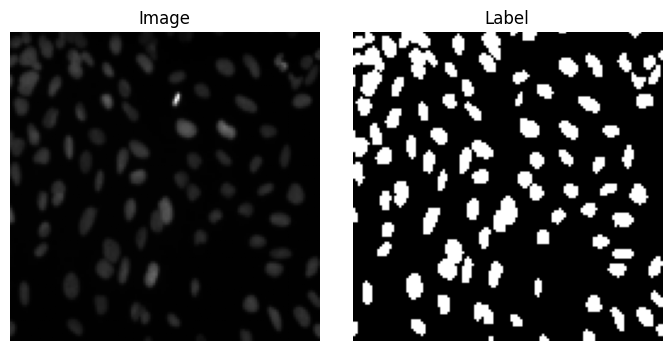

In [6]:
# Training
batch_size = 4
dataset = Nuclei()

#plot examples
fig, axs = plt.subplots(1,2, figsize=(7,3.5))
ax = axs.ravel()
for i in range(1):
    x,y = dataset[i]
    ax[i*2].imshow(x[0], cmap='gray')
    ax[i*2+1].imshow(y[0], cmap='gray')
    ax[i*2].set_title('Image')
    ax[i*2+1].set_title('Label')
    ax[i*2].axis('off')
    ax[i*2+1].axis('off')
fig.tight_layout()

In [7]:
# Split dataset
train_size = 0.8
val_size = 0.1
test_size = 0.1
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
# Model, loss, optimizer
model = UNet().to('cpu')
opt = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
summary(model, (1, 128, 128), device='cpu')
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
              ReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3         [-1, 16, 128, 128]           2,320
              ReLU-4         [-1, 16, 128, 128]               0
        DoubleConv-5         [-1, 16, 128, 128]               0
         MaxPool2d-6           [-1, 16, 64, 64]               0
            Conv2d-7           [-1, 32, 64, 64]           4,640
              ReLU-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 32, 64, 64]           9,248
             ReLU-10           [-1, 32, 64, 64]               0
       DoubleConv-11           [-1, 32, 64, 64]               0
        MaxPool2d-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          18,496
             ReLU-14           [-1, 64,

In [9]:
# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
    for X,y in pbar:
        X,y = X.to(device), y.to(device)
        opt.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward(); opt.step()
        pbar.set_postfix(loss=float(loss))


Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]/var/folders/8s/7jr95f1d28vflnwm1cfqv7t40000gr/T/ipykernel_64502/1559950389.py:12: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  pbar.set_postfix(loss=float(loss))
Epoch 5: 100%|██████████| 40/40 [00:02<00:00, 15.18it/s, loss=0.0668]


Testing: 100%|██████████| 5/5 [00:00<00:00, 16.13it/s]


Mean intersection over union on test set: 0.8977


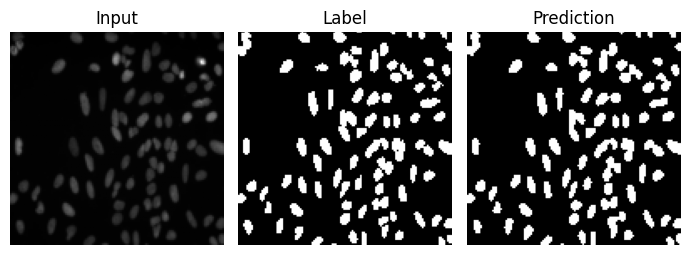

In [10]:
# Testing on the test set
model.eval()
ious = []
with torch.no_grad():
    for X,y in tqdm(test_loader, desc='Testing'):
        X,y = X.to(device), y.to(device)
        logits = model(X)
        preds = (torch.sigmoid(logits) > 0.5).float()
        intersection = (preds * y).sum(dim=(1,2,3))
        union = ((preds + y) > 0).float().sum(dim=(1,2,3))
        iou = (intersection + 1e-6) / (union + 1e-6)
        ious.extend(iou.cpu().numpy())
print(f'Mean intersection over union on test set: {np.mean(ious):.4f}')
# Visualize some predictions
fig, ax = plt.subplots(1, 3, figsize=(7, 2.5))
ax[0].imshow(X[0, 0].cpu(), cmap="gray")
ax[0].set_title("Input")
ax[1].imshow(y[0, 0].cpu(), cmap="gray")
ax[1].set_title("Label")
ax[2].imshow(preds[0, 0].cpu(), cmap="gray")
ax[2].set_title("Prediction")
for a in ax:
    a.axis("off")
fig.tight_layout()

## Exercise:

Change the UNet class to make number of features in the first conv layer (currently 16) a tunable parameter

## Coding challenge:

Tune learning rate, batch size, number of features. Leave the number of epochs at 5!

Restart the kernel and re-run the notebook (for reproducibility) to measure the test score.

Which team gets the best test score?